<a href="https://colab.research.google.com/github/AchmadRendiSetiawan/2300441100018/blob/main/Copy_of_Jurnal_Dataset_23_125_23_018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import sys

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Mencari Folder 'Original Images' di dalam Tugas_Dataset
# Kita mulai pencarian dari folder Tugas_Dataset agar lebih spesifik
search_root = '/content/drive/MyDrive/Tugas_Dataset'
data_dir = None

print(f"Sedang mencari folder 'Original Images' di dalam {search_root}...")

if not os.path.exists(search_root):
    print(f"ERROR: Folder '{search_root}' tidak ditemukan di Drive Anda.")
    print("Pastikan Anda sudah membuat folder 'Tugas_Dataset' dan mengupload datanya.")
else:
    # Deep Search: Mencari folder target dimanapun ia berada di dalam Tugas_Dataset
    for root, dirs, files in os.walk(search_root):
        for dir_name in dirs:
            if dir_name.lower().strip() == "original images":
                data_dir = os.path.join(root, dir_name)
                print(f"\n>>> DITEMUKAN! Lokasi dataset: {data_dir}")
                break
        if data_dir:
            break

if data_dir:
    print(f"Kelas Penyakit yang terdeteksi: {os.listdir(data_dir)}")
else:
    raise ValueError("Folder 'Original Images' TIDAK DITEMUKAN di dalam Tugas_Dataset. Cek kembali upload Anda.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sedang mencari folder 'Original Images' di dalam /content/drive/MyDrive/Tugas_Dataset...

>>> DITEMUKAN! Lokasi dataset: /content/drive/MyDrive/Tugas_Dataset/Potato Disease Recognition Dataset/Original Images
Kelas Penyakit yang terdeteksi: ['Potato Brown Rot Disease', 'Potato Soft Rot Disease', 'Blackspot Bruising Disease', 'Healthy Potato', 'Potato Dry Rot Disease']


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Pastikan data_dir sudah terisi dari Cell 1
if not data_dir:
    raise ValueError("Jalankan Cell 1 terlebih dahulu!")

print("Memuat Data Training...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

print("\nMemuat Data Validation...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"\nLabel Kelas: {class_names}")

# Optimasi (PENTING: Karena baca dari Drive lambat, ini akan membantu mempercepat)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Memuat Data Training...
Found 495 files belonging to 5 classes.
Using 396 files for training.

Memuat Data Validation...
Found 495 files belonging to 5 classes.
Using 99 files for validation.

Label Kelas: ['Blackspot Bruising Disease', 'Healthy Potato', 'Potato Brown Rot Disease', 'Potato Dry Rot Disease', 'Potato Soft Rot Disease']


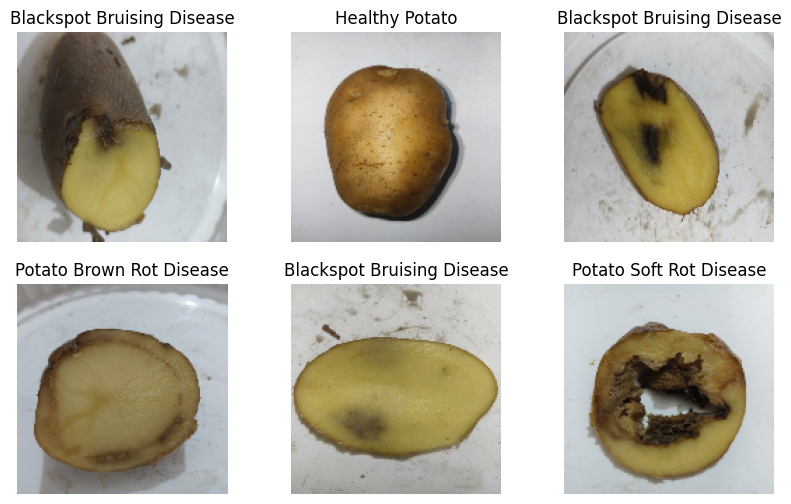

In [ ]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
# ==========================================
# CELL 4: PERBAIKAN MOBILENETV2 (FIX PREPROCESSING)
# ==========================================
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# 1. Augmentasi Data
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# 2. Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 3. Merakit Model (METODE FUNGSIONAL)
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)

# --- PERBAIKAN UTAMA DI SINI ---
# Kita ganti Rescaling(1./255) dengan preprocess_input bawaan MobileNet
# Ini akan mengubah pixel ke rentang -1 sampai 1 (Sesuai selera MobileNet)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
# -------------------------------

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

# 4. Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/tmp/ipython-input-3841745052.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ==========================================
# CELL 5: TRAINING AMAN (DENGAN CALLBACKS)
# ==========================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Definisi Callbacks (Asisten Pelatih)
# ReduceLROnPlateau: Kalau akurasi stuck 3 kali berturut-turut, kurangi learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

# EarlyStopping: Kalau 10 kali epoch tidak ada kemajuan, stop otomatis (biar hemat waktu)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

# 2. Latih Model (Epoch diperbanyak, tapi aman karena ada EarlyStopping)
EPOCHS = 50

print("Mulai Training Teroptimasi...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[reduce_lr, early_stop] # Masukkan asisten pelatih di sini
)

Mulai Training Teroptimasi...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1540 - loss: 2.6237 - val_accuracy: 0.2626 - val_loss: 1.8036 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 847ms/step - accuracy: 0.2398 - loss: 2.0619 - val_accuracy: 0.3232 - val_loss: 1.5347 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 896ms/step - accuracy: 0.3409 - loss: 1.7333 - val_accuracy: 0.4242 - val_loss: 1.3564 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 838ms/step - accuracy: 0.3642 - loss: 1.6763 - val_accuracy: 0.5253 - val_loss: 1.2439 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 840ms/step - accuracy: 0.4500 - loss: 1.5023 - val_accuracy: 0.5556 - val_loss: 1.1668 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 859ms/step - accuracy: 0.4187 - loss: 1.5259 - val_accuracy: 0.5758 - val_loss: 1.1113 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━

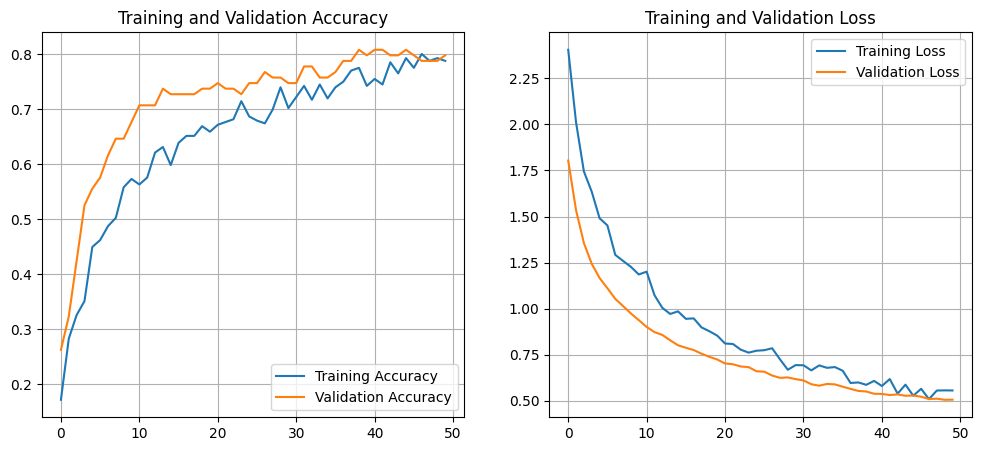

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()

Menghitung Evaluasi pada Data Validasi...


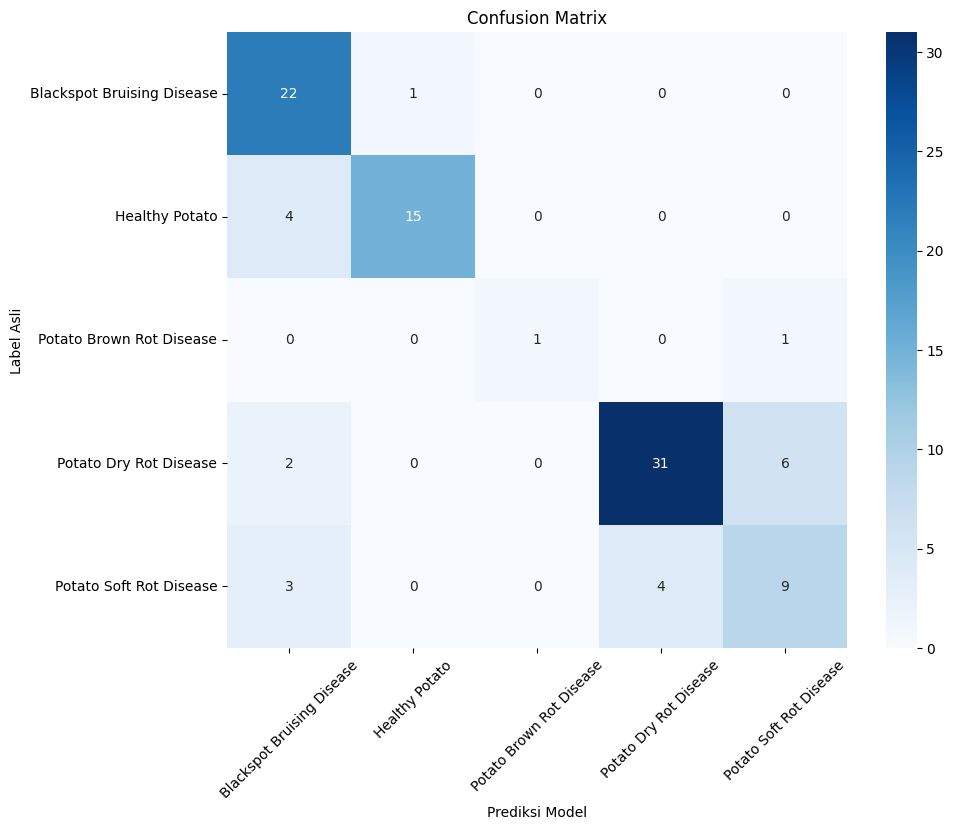


=== LAPORAN KLASIFIKASI ===
                            precision    recall  f1-score   support

Blackspot Bruising Disease       0.71      0.96      0.81        23
            Healthy Potato       0.94      0.79      0.86        19
  Potato Brown Rot Disease       1.00      0.50      0.67         2
    Potato Dry Rot Disease       0.89      0.79      0.84        39
   Potato Soft Rot Disease       0.56      0.56      0.56        16

                  accuracy                           0.79        99
                 macro avg       0.82      0.72      0.75        99
              weighted avg       0.80      0.79      0.79        99



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Menghitung Evaluasi pada Data Validasi...")

# Ambil Label Asli dan Prediksi
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# 2. Laporan Klasifikasi Lengkap
print("\n=== LAPORAN KLASIFIKASI ===")
print(classification_report(y_true, y_pred, target_names=class_names))

Tes Prediksi 5 Gambar Acak...


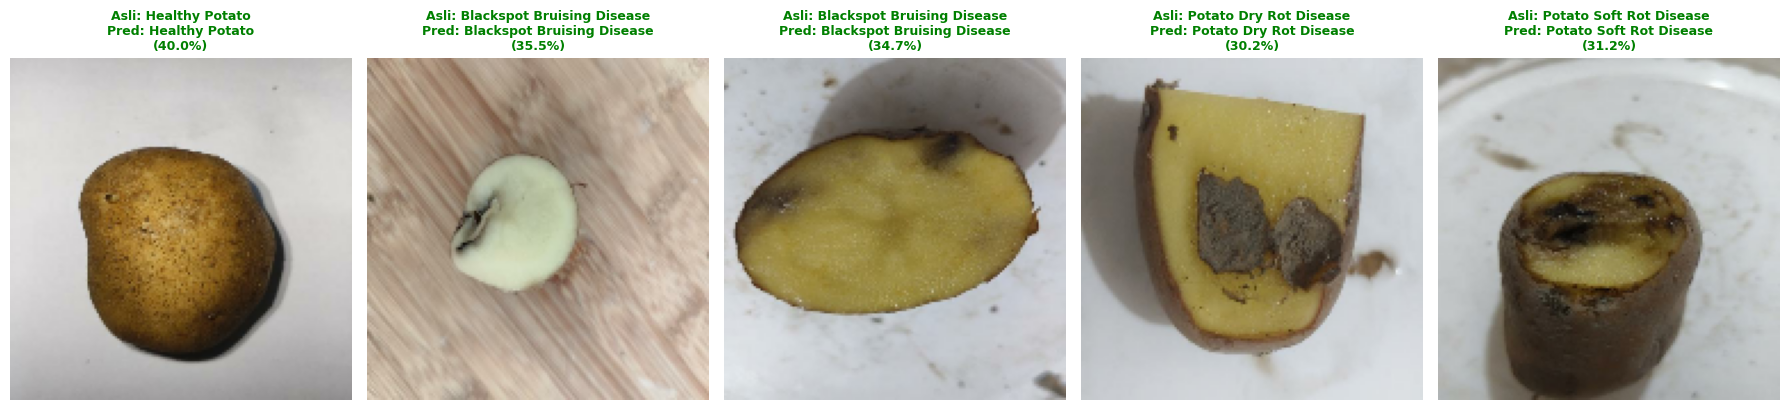

In [ ]:
print("Tes Prediksi 5 Gambar Acak...")

plt.figure(figsize=(18, 6))
image_batch, label_batch = next(iter(val_ds))
indices = np.random.choice(range(len(image_batch)), 5, replace=False)

for i, idx in enumerate(indices):
    img = image_batch[idx]
    label = label_batch[idx]

    img_array = tf.expand_dims(img, 0)
    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])

    # Ambil nama kelas LENGKAP tanpa dipotong
    predicted_label = class_names[np.argmax(score)]
    actual_label = class_names[label]
    confidence = 100 * np.max(score)

    color = 'green' if predicted_label == actual_label else 'red'

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))

    # Tampilkan teks lengkap dengan format rapi
    plt.title(f"Asli: {actual_label}\nPred: {predicted_label}\n({confidence:.1f}%)",
              color=color, fontsize=9, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()